In [1]:
import pandas as pd
import yfinance as yf
import yfinance as yf
from curl_cffi import requests as curl_requests
session = curl_requests.Session(impersonate="chrome")


# === SETTINGS ===
start_date = '1960-01-01'
end_date = '2024-12-31'
ticker = "WPSGX" ### Điền đầu cổ phiếu

# === LOAD MACRO DATA ===
cci_df = pd.read_csv('cci.csv', parse_dates=['observation_date']).set_index('observation_date').sort_index()
gdp_df = pd.read_csv('gdp.csv', parse_dates=['observation_date']).set_index('observation_date').sort_index()
interest_df = pd.read_csv('interest_rate.csv', parse_dates=['observation_date']).set_index('observation_date').sort_index()
unemployment_df = pd.read_csv('unemployment_rate.csv', parse_dates=['observation_date']).set_index('observation_date').sort_index()

# Filter macro data to date range
cci_df = cci_df[start_date:end_date]
gdp_df = gdp_df[start_date:end_date]
interest_df = interest_df[start_date:end_date]
unemployment_df = unemployment_df[start_date:end_date]

# Daily resampling
cci_daily = cci_df['cci'].resample('D').ffill()
gdp_daily = gdp_df['gdp'].resample('D').ffill()
interest_daily = interest_df['interest_rate'].resample('D').ffill()
unemployment_daily = unemployment_df['unemployment_rate'].resample('D').ffill()

# === INFLATION DATA ===
inflation_df = pd.read_csv('inflation_rate.csv')
dates, inflation_rates = [], []

for _, row in inflation_df.iterrows():
    year = int(row['Year'])
    for month in range(1, 13):
        month_abbr = pd.to_datetime(f"{year}-{month:02d}-01").strftime('%b')
        month_abbr_upper = month_abbr.upper()
        if month_abbr_upper in row:
            dates.append(pd.to_datetime(f"{year}-{month:02d}-01"))
            inflation_rates.append(row[month_abbr_upper])
        elif month_abbr in row:
            dates.append(pd.to_datetime(f"{year}-{month:02d}-01"))
            inflation_rates.append(row[month_abbr])
        else:
            continue

inflation_series = pd.DataFrame({'InflationRate': inflation_rates}, index=pd.to_datetime(dates))
inflation_series = inflation_series[start_date:end_date]
inflation_daily = inflation_series['InflationRate'].resample('D').ffill()

# === COMBINE MACRO DATA ===
all_daily_indicators = pd.DataFrame({
    'CCI': cci_daily,
    'GDP_Growth': gdp_daily,
    'InterestRate': interest_daily,
    'UnemploymentRate': unemployment_daily,
    'InflationRate': inflation_daily
}, index=pd.date_range(start=start_date, end=end_date, freq='D'))

# Fill any initial NaNs
all_daily_indicators = all_daily_indicators.ffill()

# === STOCK DATA ===
print(f"\nDownloading data for {ticker} from Yahoo Finance...")
stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, session=session)

if 'Adj Close' not in stock_data.columns:
    raise ValueError(f"'Adj Close' not found in stock data for {ticker}. Please check if the ticker is valid.")

stock_price = stock_data['Adj Close']
stock_price.name = 'StockPrice'

# Combine with macro data
combined_df = all_daily_indicators.join(stock_price, how='left')
combined_df.info()

# === OUTPUT ===
print("\nCombined Data (head):")
print(combined_df.head())

print("\nCombined Data (tail):")
print(combined_df.tail())

combined_df.info()
combined_df.dropna(subset=[ticker],inplace=True)

# Optionally save to CSV
combined_df.to_csv(f"{ticker}_with_macro.csv")
combined_df.info()
print("done")

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23742 entries, 1960-01-01 to 2024-12-31
Freq: D
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CCI               23742 non-null  float64
 1   GDP_Growth        23742 non-null  float64
 2   InterestRate      23742 non-null  float64
 3   UnemploymentRate  23742 non-null  float64
 4   InflationRate     23742 non-null  float64
 5   WPSGX             7762 non-null   float64
dtypes: float64(6)
memory usage: 1.3 MB

Combined Data (head):
                 CCI  GDP_Growth  InterestRate  UnemploymentRate  \
1960-01-01  101.6328         9.3          3.99               5.2   
1960-01-02  101.6328         9.3          3.99               5.2   
1960-01-03  101.6328         9.3          3.99               5.2   
1960-01-04  101.6328         9.3          3.99               5.2   
1960-01-05  101.6328         9.3          3.99               5.2   

            Inflati

cuda
Layer (type:depth-idx)                   Param #
├─BatchNorm1d: 1-1                       12
├─decomp: 1-2                            --
|    └─SMA: 2-1                          --
|    |    └─AvgPool1d: 3-1               --
├─Linear: 1-3                            6,030
├─Linear: 1-4                            6,030
├─Linear: 1-5                            6,030
├─Linear: 1-6                            3,968
├─Linear: 1-7                            3,870
├─Linear: 1-8                            25,728
├─RevIN: 1-9                             12
├─xLSTMBlockStack: 1-10                  --
|    └─ModuleList: 2-2                   --
|    |    └─mLSTMBlock: 3-2              109,448
|    |    └─mLSTMBlock: 3-3              109,448
|    |    └─mLSTMBlock: 3-4              109,448
|    |    └─mLSTMBlock: 3-5              109,448
|    |    └─mLSTMBlock: 3-6              109,448
|    └─LayerNorm: 2-3                    128
├─Dropout: 1-11                          --
Total params: 599,048

C:\Users\minhk\AppData\Local\Temp\ipykernel_25404\924968439.py:197: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_raw = df_raw.fillna(method='ffill')


Epoch [1/150]  |  Avg. Epoch Time: 0.82 sec  |  Train Loss: 2.211E-03  |  Val Loss: 2.098E-03  |  LR: 1.000E-03
Epoch [5/150]  |  Avg. Epoch Time: 0.55 sec  |  Train Loss: 6.773E-04  |  Val Loss: 6.109E-04  |  LR: 1.000E-03
Epoch [10/150]  |  Avg. Epoch Time: 0.52 sec  |  Train Loss: 2.488E-04  |  Val Loss: 3.412E-04  |  LR: 1.000E-03
Epoch [15/150]  |  Avg. Epoch Time: 0.53 sec  |  Train Loss: 1.451E-04  |  Val Loss: 3.189E-04  |  LR: 5.000E-04
Epoch [20/150]  |  Avg. Epoch Time: 0.51 sec  |  Train Loss: 1.065E-04  |  Val Loss: 3.009E-04  |  LR: 1.250E-04
Epoch [25/150]  |  Avg. Epoch Time: 0.50 sec  |  Train Loss: 9.714E-05  |  Val Loss: 3.261E-04  |  LR: 3.125E-05
Epoch [30/150]  |  Avg. Epoch Time: 0.51 sec  |  Train Loss: 9.545E-05  |  Val Loss: 3.285E-04  |  LR: 3.906E-06
Epoch [35/150]  |  Avg. Epoch Time: 0.50 sec  |  Train Loss: 9.510E-05  |  Val Loss: 3.284E-04  |  LR: 9.766E-07
Epoch [40/150]  |  Avg. Epoch Time: 0.50 sec  |  Train Loss: 9.503E-05  |  Val Loss: 3.286E-04  | 

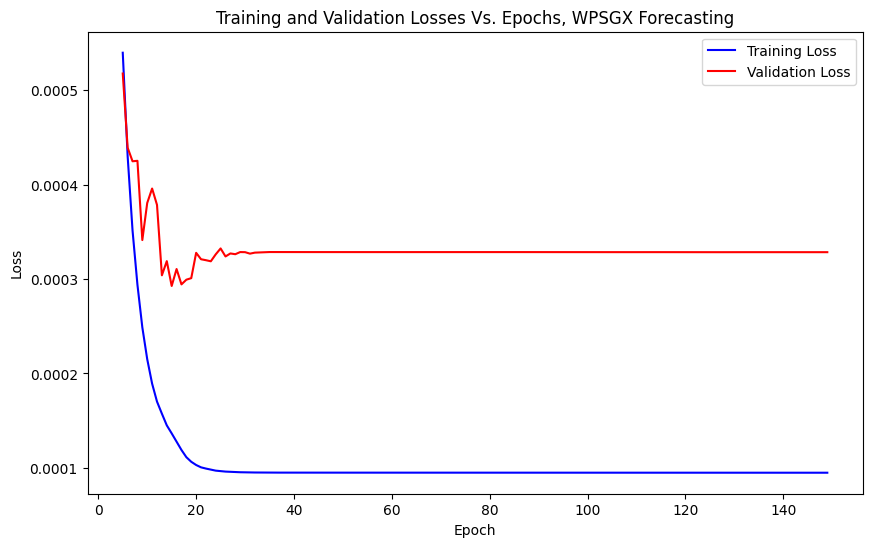

Ground truth length: 7738
Total predictions length: 7048
Train predictions length: 4722
Validation predictions length: 1008
Test predictions length: 1318
Train begin index: 200, end: 4922
Validation begin index: 5152, end: 6160
Test begin index: 6390, end: 7708


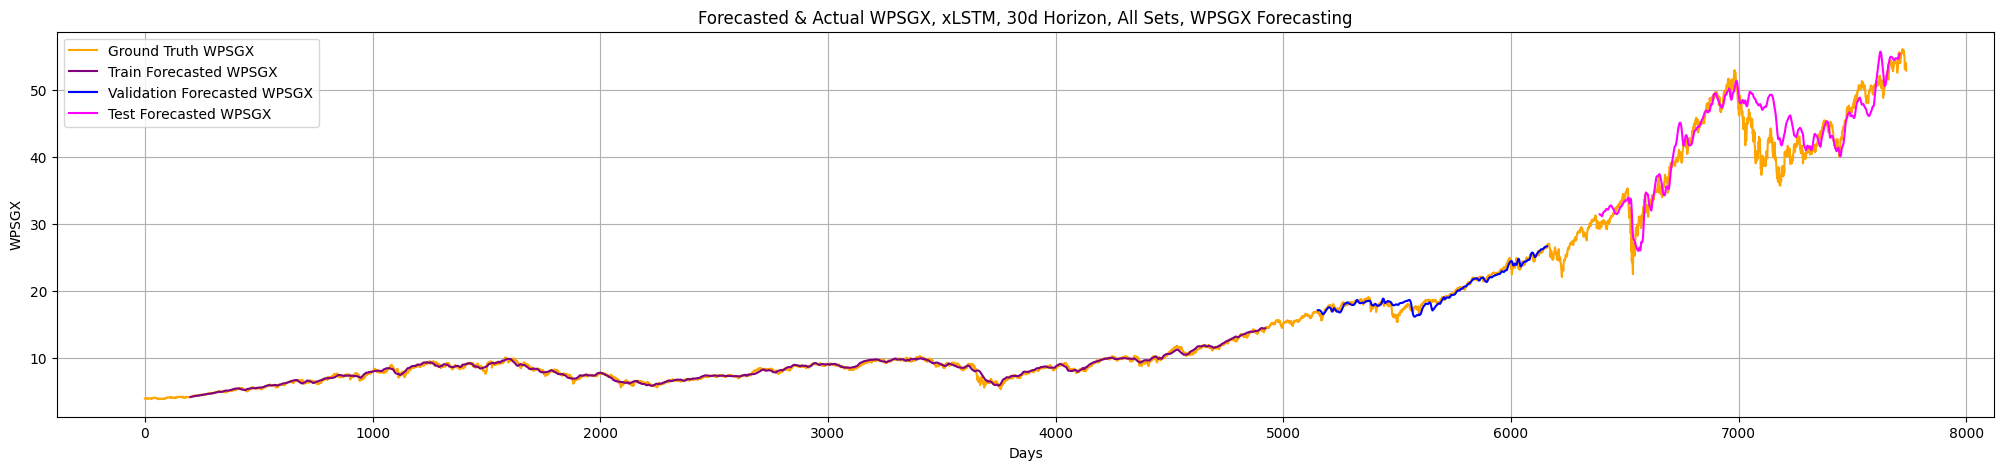

Test loss: 2.494E-03
Ground truth length: 7738
Total predictions length: 7048
Train predictions length: 4722
Validation predictions length: 1008
Test predictions length: 1318
Train begin index: 200, end: 4922
Validation begin index: 5152, end: 6160
Test begin index: 6390, end: 7708


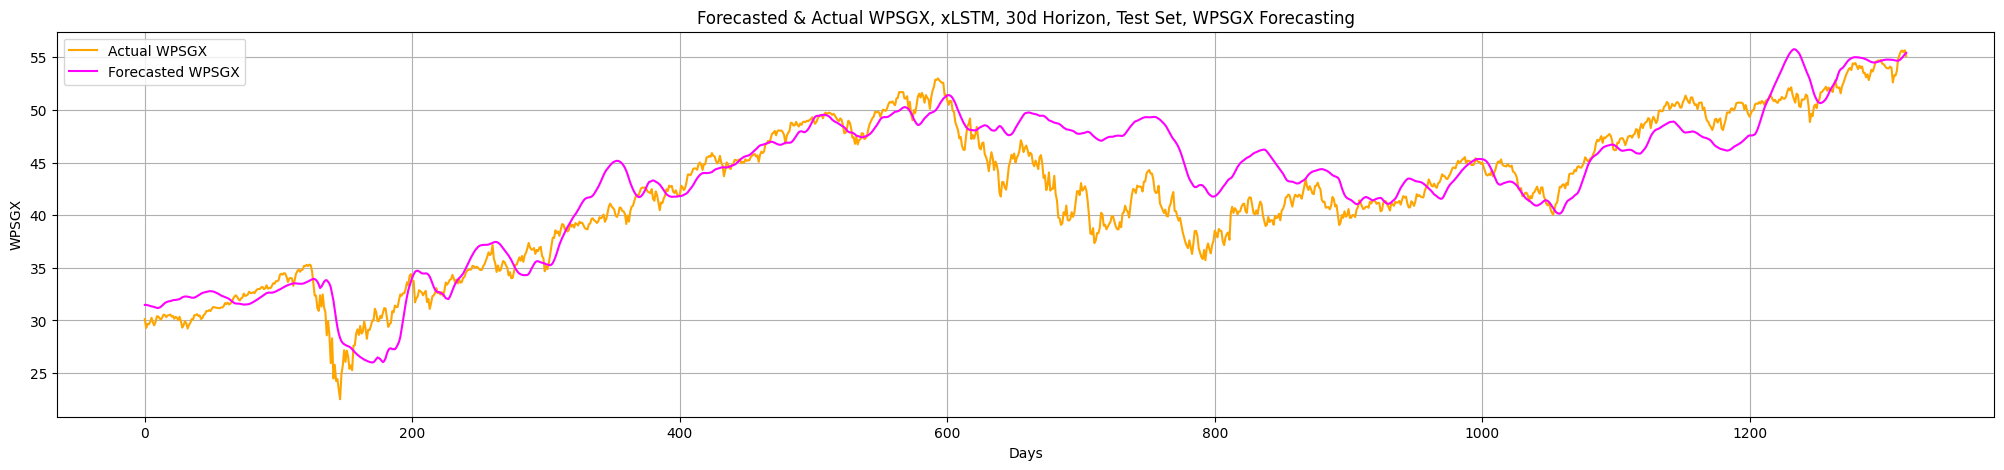

In [2]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
)
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from torchsummary import summary
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Set random seeds for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# General Constants
config_dict = {
    "data": {
        "rolling_window": 25,
        "lookback": 200,
        "horizon": 30,
        "split_ratios": {'train': 0.64, 'val': 0.16, 'test': 0.2},
    },
    "model": {
        "num_features": 6,
        "num_blocks": 5,
        "embedding_dim": 128,
        "context_length": 336,
        "sma_ksize": 25
    },
    "training": {
        "batch_size": 512,
        "epochs": 150,
        "lr": 1e-3,
        "min_lr": 1e-10,
        "sched_factor": 0.5,
        "sched_threshold": 1e-5
    },
}

# Commonly used constants
offset = config_dict['data']['rolling_window'] // 2
lookback = config_dict['data']['lookback']
horizon = config_dict['data']['horizon']
batch_size = config_dict['training']['batch_size']
epochs = config_dict['training']['epochs']

# Submodule and Model Definitions
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

class Config:
    def __init__(self, seq_len, fcast_horizon, emb_dim2, sma_ksize, num_features):
        self.seq_len = seq_len
        self.fcast_horizon = fcast_horizon
        self.emb_dim2 = emb_dim2
        self.sma_ksize = sma_ksize
        self.num_features = num_features

class SMA(nn.Module):
    def __init__(self, kernel_size):
        super(SMA, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        back = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, back], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class decomp(nn.Module):
    def __init__(self, kernel_size):
        super(decomp, self).__init__()
        self.sma = SMA(kernel_size)

    def forward(self, x):
        trend = self.sma(x)
        seasonal = x - trend
        return seasonal, trend

class xlstm(nn.Module):
    def __init__(self, cfg, bs_cfg):
        super(xlstm, self).__init__()
        self.cfg = cfg
        self.bn = nn.BatchNorm1d(cfg.num_features)
        self.decomp = decomp(kernel_size=cfg.sma_ksize)
        self.LinearSeasonal = nn.Linear(cfg.seq_len, cfg.fcast_horizon)
        self.LinearTrend = nn.Linear(cfg.seq_len, cfg.fcast_horizon)
        self.LinearDecoder = nn.Linear(cfg.seq_len, cfg.fcast_horizon)
        self.LinearSeasonal.weight = nn.Parameter((1 / cfg.seq_len) * torch.ones([cfg.fcast_horizon, cfg.seq_len]))
        self.LinearTrend.weight = nn.Parameter((1 / cfg.seq_len) * torch.ones([cfg.fcast_horizon, cfg.seq_len]))
        self.mm1 = nn.Linear(cfg.fcast_horizon, cfg.emb_dim2)
        self.mm2 = nn.Linear(bs_cfg.embedding_dim, cfg.fcast_horizon)
        self.mm3 = nn.Linear(cfg.seq_len, cfg.emb_dim2)
        self.revin = RevIN(cfg.num_features)
        self.xlstm_stack = xLSTMBlockStack(bs_cfg)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.revin(x, 'norm')
        seasonal, trend = self.decomp(x)
        seasonal, trend = seasonal.permute(0, 2, 1), trend.permute(0, 2, 1)
        seasonal_out = self.LinearSeasonal(seasonal)
        trend_out = self.LinearTrend(trend)
        x = seasonal_out + trend_out
        x = self.mm1(x)
        x = self.xlstm_stack(x)
        x = self.mm2(x)
        x = x.permute(0, 2, 1)
        x = self.revin(x, 'denorm')
        return x

# Trainer Class
class trainer:
    def __init__(self, csv_path, ticker):
        self.csv_path = csv_path
        self.ticker = ticker
        self.company = f"{self.ticker} Forecasting"
        self.model_stats = None
        self.trained = False
        self.has_all_predictions = False
        self.has_set_indices = False
        self.anim = None
        self.losses = {'Train': None, 'Validation': None, 'Test': None}
        self.__download_and_preprocess_data()
        self.__create_set_tensors()
        self.__init_model()

    def __download_and_preprocess_data(self):
        df_raw = pd.read_csv(self.csv_path, index_col=0, parse_dates=True)
        df_raw = df_raw.reset_index(drop=True)
        features = ['CCI', 'GDP_Growth', 'InterestRate', 'UnemploymentRate', 'InflationRate', self.ticker]
        df_raw = df_raw[features]
        df_raw = df_raw.fillna(method='ffill')
        df = df_raw.rolling(config_dict['data']['rolling_window']).mean()
        df.dropna(how='any', axis=0, inplace=True)
        df[self.ticker] = np.log(df[self.ticker])
        dataset = df.values.astype('float32')
        self.df_raw = df_raw
        self.df = df
        self.df_processed = df
        self.scaler = MinMaxScaler()
        self.dataset = self.scaler.fit_transform(dataset)
        self.raw_offset = len(df_raw) - len(df)

    def __create_features_labels(self, dataset, lookback, horizon):
        X, y = [], []
        for i in range(len(dataset) - lookback - horizon):
            X.append(dataset[i: i + lookback])
            y.append(dataset[i + lookback: i + lookback + horizon])
        return torch.from_numpy(np.array(X)).float(), torch.from_numpy(np.array(y)).float()

    def __create_set_tensors(self):
        full_size = len(self.dataset)
        self.train_size = int(full_size * config_dict["data"]["split_ratios"]['train'])
        self.val_size = int(full_size * config_dict["data"]["split_ratios"]['val'])
        self.test_size = full_size - self.train_size - self.val_size
        train_set = self.dataset[:self.train_size, :]
        val_set = self.dataset[self.train_size:self.train_size + self.val_size, :]
        test_set = self.dataset[self.train_size + self.val_size:, :]
        X_train, y_train = self.__create_features_labels(train_set, lookback, horizon)
        X_val, y_val = self.__create_features_labels(val_set, lookback, horizon)
        X_test, y_test = self.__create_features_labels(test_set, lookback, horizon)
        self.train_set_tensor = TensorDataset(X_train, y_train)
        self.val_set_tensor = TensorDataset(X_val, y_val)
        self.test_set_tensor = TensorDataset(X_test, y_test)
        self.train_len = len(self.train_set_tensor)
        self.val_len = len(self.val_set_tensor)
        self.test_len = len(self.test_set_tensor)

    def __init_data_loaders(self, shuffle_train=True):
        batch_size = config_dict["training"]["batch_size"]
        self.train_loader = DataLoader(self.train_set_tensor, batch_size=batch_size, shuffle=shuffle_train)
        self.val_loader = DataLoader(self.val_set_tensor, batch_size=batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_set_tensor, batch_size=batch_size, shuffle=False)

    def __init_model(self):
        block_stack_config = xLSTMBlockStackConfig(
            mlstm_block=mLSTMBlockConfig(mlstm=mLSTMLayerConfig(bias=True)),
            slstm_block=sLSTMBlockConfig(),
            num_blocks=config_dict["model"]["num_blocks"],
            embedding_dim=config_dict["model"]["embedding_dim"],
            add_post_blocks_norm=True,
            _block_map=1,
            context_length=config_dict["model"]["context_length"],
        )
        config = Config(
            seq_len=config_dict['data']['lookback'],
            fcast_horizon=config_dict['data']['horizon'],
            emb_dim2=config_dict["model"]["embedding_dim"],
            sma_ksize=config_dict["model"]["sma_ksize"],
            num_features=config_dict["model"]["num_features"]
        )
        self.model = xlstm(cfg=config, bs_cfg=block_stack_config).to(device)

    def __init_train(self):
        self.criterion = nn.MSELoss(reduction='mean')
        self.optimizer = optim.RAdam(self.model.parameters(), lr=config_dict["training"]["lr"])
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            factor=config_dict["training"]["sched_factor"],
            threshold=config_dict["training"]["sched_threshold"],
            min_lr=config_dict["training"]["min_lr"],
            patience=1
        )

    def train(self, verbose_progress=True):
        self.__init_train()
        self.__init_data_loaders()
        train_losses = []
        val_losses = []
        epochs = config_dict["training"]["epochs"]
        start_time = time.time()
        for epoch in range(epochs):
            self.model.train()
            running_train_loss = 0.0
            epoch_time = time.time()
            for i, (X_batch, y_batch) in enumerate(self.train_loader, 0):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = self.model(X_batch)
                train_loss = self.criterion(torch.exp(outputs[:, :, -1]), torch.exp(y_batch[:, :, -1]))
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()
                running_train_loss += train_loss.item() * X_batch.size(0)
            epoch_train_loss = running_train_loss / len(self.train_loader.dataset)
            train_losses.append(epoch_train_loss)
            epoch_val_loss = self.__evaluate()
            val_losses.append(epoch_val_loss)
            self.scheduler.step(epoch_val_loss)
            if verbose_progress and ((epoch + 1) % 5 == 0 or epoch == 0):
                avg_epoch_time = (time.time() - start_time) / (epoch + 1)
                print(f'Epoch [{epoch + 1}/{epochs}]  |  '
                      f'Avg. Epoch Time: {avg_epoch_time:.2f} sec  |  '
                      f'Train Loss: {epoch_train_loss:.3E}  |  '
                      f'Val Loss: {epoch_val_loss:.3E}  |  '
                      f'LR: {self.scheduler.get_last_lr()[-1]:.3E}')
        self.train_losses = train_losses
        self.val_losses = val_losses
        self.trained = True

    def __evaluate(self):
        self.model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for _, (X_batch, y_batch) in enumerate(self.val_loader, 0):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                val_outputs = self.model(X_batch)
                val_loss = self.criterion(torch.exp(val_outputs[:, :, -1]), torch.exp(y_batch[:, :, -1]))
                running_val_loss += val_loss.item() * X_batch.size(0)
        epoch_val_loss = running_val_loss / len(self.val_loader.dataset)
        return epoch_val_loss

    def __predict(self, data_loader, data_desc):
        self.model.eval()
        predicted_prices = np.array([])
        running_loss = 0.0
        with torch.no_grad():
            for _, (X_batch, y_batch) in enumerate(data_loader):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = self.model(X_batch)
                loss = self.criterion(torch.exp(preds[:, :, -1]), torch.exp(y_batch[:, :, -1]))
                running_loss += loss.item() * X_batch.size(0)
                preds = preds.cpu().numpy()
                preds = np.array([self.scaler.inverse_transform(preds[i]) for i in range(preds.shape[0])])
                predicted_prices = np.concatenate((predicted_prices, np.exp(preds[:, -1, -1])))
            total_loss = running_loss / len(data_loader.dataset)
        self.losses[data_desc] = total_loss
        return predicted_prices

    def print_model_stats(self):
        if self.model_stats is None:
            self.model_stats = summary(
                model=self.model,
                dtypes=[torch.float, torch.float],
                batch_dim=1,
                device=device,
                verbose=0
            )
        print(str(self.model_stats))

    def plot_losses(self, from_epoch=0):
        if not self.trained:
            raise AttributeError('Model has not been trained')
        if from_epoch < 0 or from_epoch > epochs - 1:
            raise ValueError(f'from_epoch must be in the range [0, {epochs - 1}]')
        indices = np.arange(from_epoch, epochs)
        plt.figure(figsize=(10, 6))
        plt.plot(indices, self.train_losses[from_epoch:], label='Training Loss', color='blue')
        plt.plot(indices, self.val_losses[from_epoch:], label='Validation Loss', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Losses Vs. Epochs, {self.company}')
        plt.legend()
        plt.show()

    def __get_all_predictions(self):
        self.__init_data_loaders(shuffle_train=False)
        loaders = [self.train_loader, self.val_loader, self.test_loader]
        descriptions = ['Train', 'Validation', 'Test']
        all_predictions = np.array([])
        for i, loader in enumerate(loaders):
            pred = self.__predict(loader, descriptions[i])
            all_predictions = np.concatenate((all_predictions, pred))
        self.all_predictions = all_predictions

    def __get_set_indices(self):
        lookback = config_dict['data']['lookback']
        self.train_begin_idx = lookback
        self.train_end_idx = self.train_begin_idx + self.train_len
        self.val_begin_idx = self.train_size + lookback
        self.val_end_idx = self.val_begin_idx + self.val_len
        self.test_begin_idx = self.train_size + self.val_size + lookback
        self.test_end_idx = self.test_begin_idx + self.test_len

    def autoregress_forecast(self, initial_window, forecast_steps):
        self.model.eval()
        window = initial_window.clone().to(device)
        all_predictions = []
        steps_per_horizon = self.model.cfg.fcast_horizon
        num_iterations = (forecast_steps + steps_per_horizon - 1) // steps_per_horizon
        with torch.no_grad():
            for _ in range(num_iterations):
                pred = self.model(window)
                pred = pred.cpu().numpy()
                pred_descaled = self.scaler.inverse_transform(pred[0])
                pred_ticker = np.exp(pred_descaled[:, -1])
                remaining_steps = forecast_steps - len(all_predictions)
                steps_to_take = min(steps_per_horizon, remaining_steps)
                all_predictions.extend(pred_ticker[:steps_to_take])
                if len(all_predictions) >= forecast_steps:
                    break
                pred_tensor = torch.from_numpy(pred).float().to(device)
                window = torch.cat((window[:, steps_to_take:, :], pred_tensor[:, :steps_to_take, :]), dim=1)
        return np.array(all_predictions[:forecast_steps])

    def plot_set(self, sets):
        if not self.trained:
            raise AttributeError('Model has not been trained')
        if sets not in ['all', 'test']:
            raise ValueError("Argument 'sets' must be either 'all' or 'test'")
        if not self.has_all_predictions:
            self.__get_all_predictions()
            self.has_all_predictions = True
        if not self.has_set_indices:
            self.__get_set_indices()
            self.has_set_indices = True
        if sets == 'test':
            print(f"Test loss: {self.losses['Test']:.3E}")
        plt.figure(figsize=(25, 5))
        start_idx = self.raw_offset
        ground_truth = self.df_raw[self.ticker].iloc[start_idx:].reset_index(drop=True)
        if sets == 'test':
            df_raw_test = ground_truth[self.test_begin_idx:self.test_end_idx].reset_index(drop=True)
            plt.plot(df_raw_test, label=f'Actual {self.ticker}', color='orange')
            plt.plot(self.all_predictions[self.train_len + self.val_len:], label=f'Forecasted {self.ticker}', color='magenta')
            title_str = f'Forecasted & Actual {self.ticker}, xLSTM, 30d Horizon, Test Set, {self.company}'
        else:
            plt.plot(ground_truth, label=f'Ground Truth {self.ticker}', color='orange')
            plt.plot(np.arange(self.train_begin_idx, self.train_end_idx), self.all_predictions[:self.train_len], label=f'Train Forecasted {self.ticker}', color='purple')
            plt.plot(np.arange(self.val_begin_idx, self.val_end_idx), self.all_predictions[self.train_len:self.train_len + self.val_len], label=f'Validation Forecasted {self.ticker}', color='blue')
            plt.plot(np.arange(self.test_begin_idx, self.test_end_idx), self.all_predictions[self.train_len + self.val_len:], label=f'Test Forecasted {self.ticker}', color='magenta')
            title_str = f'Forecasted & Actual {self.ticker}, xLSTM, 30d Horizon, All Sets, {self.company}'
        print(f"Ground truth length: {len(ground_truth)}")
        print(f"Total predictions length: {len(self.all_predictions)}")
        print(f"Train predictions length: {self.train_len}")
        print(f"Validation predictions length: {self.val_len}")
        print(f"Test predictions length: {self.test_len}")
        print(f"Train begin index: {self.train_begin_idx}, end: {self.train_end_idx}")
        print(f"Validation begin index: {self.val_begin_idx}, end: {self.val_end_idx}")
        print(f"Test begin index: {self.test_begin_idx}, end: {self.test_end_idx}")
        plt.xlabel('Days')
        plt.ylabel(self.ticker)
        plt.title(title_str)
        plt.legend()
        plt.grid()
        plt.show()

# Example Usage
csv_trainer = trainer(f'C:/Users/minhk/xLSTM/Raw data/{ticker}_with_macro.csv', ticker)
csv_trainer.print_model_stats()
csv_trainer.train()
csv_trainer.plot_losses(from_epoch=5)
csv_trainer.plot_set('all')
csv_trainer.plot_set('test')

mod_test_loader = DataLoader(csv_trainer.test_set_tensor, batch_size=1, shuffle=False)
iterator = iter(mod_test_loader)
X_batch, _ = next(iterator)
X_batch = X_batch.to(device)
